In [10]:
import scipy.io
from scipy.signal import butter, lfilter, filtfilt, iirnotch, sosfilt
import numpy as np
import matplotlib.pyplot as plt

# import required module
import os

In [16]:
def extract_data_within_intervals(base_path):
    participants = ['pp1', 'pp3', 'pp4', 'pp5', 'pp6', 'pp7', 'pp8', 'pp9', 'pp10']
    all_emg_data = []
    key = 'anterior'

    for participant in participants:
        emg_path = os.path.join(base_path, participant, 'EMG')
        pertinfo_path = os.path.join(base_path, participant, 'pertinfo')
        
        # Process EMG files and pertinfo files
        for emg_file in os.listdir(emg_path):
            if key in emg_file:
                emg_full_path = os.path.join(emg_path, emg_file)
                emg_mat = scipy.io.loadmat(emg_full_path)
                data_EMG = emg_mat['data_EMG']

                # Corresponding pertinfo file
                pertinfo_file = emg_file.replace('EMG', 'pertinfo')  # Adjust if necessary
                pertinfo_full_path = os.path.join(pertinfo_path, pertinfo_file)
                
                if os.path.exists(pertinfo_full_path):
                    pert_mat = scipy.io.loadmat(pertinfo_full_path)
                    #time_intervals = pert_mat['time_start_stop']
                    #time_intervals = [0]

                    time_intervals = pert_mat['time_start_stop']
                    time_intervals = time_intervals[0]
                    
                    #start_time, end_time = 1000, 4000
                    start_time, end_time = int(time_intervals[0]* 1000) - 1000 , int(time_intervals[1] *1000)
                    duration = 3000
                    if 'emg_headers' in emg_mat:
                        emg_headers = [h[0] for h in emg_mat['emg_headers'][0]]
                        emg_data_dict = {header: [] for header in emg_headers}

                        # Extract data for each header within the interval
                        for i, header in enumerate(emg_headers):
                            data_slice = data_EMG[start_time:start_time + duration, i]
                            if not np.isnan(data_slice).all():
                                emg_data_dict[header].append(data_slice)

                        all_emg_data.append({
                            'participant': participant,
                            'file': emg_file,
                            'interval': (start_time, end_time),
                            'data': emg_data_dict
                        })

    return all_emg_data

base_path = '../../Downloads/YoungData_vEMG/YoungData_vEMG'  # Adjust this path as needed
emg_data_within_intervals = extract_data_within_intervals(base_path)

In [17]:
fs = 1000  # Sampling frequency in Hz
lowcut = 20.0  # High-pass filter cutoff frequency
notch_freq = 60.0  # Notch filter frequency
notch_quality_factor = 30.0  # Quality factor for the notch filter
lowpass_freq = 10.0

def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    sos = butter(order, normal_cutoff, btype='high', output='sos')
    return sos

def apply_notch_filter(freq, quality_factor, fs):
    nyq = 0.5 * fs
    freq = freq / nyq
    b, a = iirnotch(freq, quality_factor)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=4):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    sos = butter(order, normal_cutoff, btype='low', output='sos')
    return sosfilt(sos, data)

In [27]:
processed_data = []
for participant_data in emg_data_within_intervals:
    participant_id = participant_data['participant']
    file_id = participant_data['file']
    interval = participant_data['interval']
    muscles_data = participant_data['data']

    processed_muscles = {}

    for muscle, emg_arrays in muscles_data.items():
        if emg_arrays:  # Check if there is data for this muscle
            emg_signal = emg_arrays[0]  # Assuming there is only one array per muscle as per your example

            # High-pass filter
            sos = butter_highpass(lowcut, fs)
            filtered_emg = sosfilt(sos, emg_signal)

            # Notch filter
            b, a = apply_notch_filter(notch_freq, notch_quality_factor, fs)
            filtered_emg = filtfilt(b, a, filtered_emg)

            # Rectification
            rectified_emg = np.abs(filtered_emg)

            # Envelope extraction
            envelope = butter_lowpass_filter(rectified_emg, lowpass_freq, fs)

            # Store processed data for the muscle
            processed_muscles[muscle] = envelope
    
    processed_data.append({
        'participant': participant_id,
        'file': file_id,
        'interval': interval,
        'data': processed_muscles
    })

In [28]:
import matplotlib
plt.style.use('seaborn')  # Using a predefined style for a modern and clean look

# Define a consistent font style
font = {'family': 'serif',
        'weight': 'normal',
        'size': 14}
matplotlib.rc('font', **font)

C:\Users\chery\AppData\Local\Temp\ipykernel_8836\462531483.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')  # Using a predefined style for a modern and clean look


[7.14936354e-09 6.19222392e-08 2.70343720e-07 8.13150414e-07
 1.93243163e-06 3.91633344e-06 7.09436953e-06 1.18454509e-05
 1.86049845e-05 2.78562281e-05]
[7.32703911e-09 6.38126374e-08 2.79709127e-07 8.43350805e-07
 2.00716518e-06 4.07206491e-06 7.37835413e-06 1.23033140e-05
 1.92640613e-05 2.87187206e-05]
[7.27034012e-09 6.43389562e-08 2.84079146e-07 8.56531137e-07
 2.03097202e-06 4.10476640e-06 7.42049656e-06 1.23553039e-05
 1.93031551e-05 2.86579544e-05]
[4.58426900e-09 4.05550510e-08 1.79822511e-07 5.46413837e-07
 1.30874718e-06 2.67377427e-06 4.88275771e-06 8.20251725e-06
 1.29158296e-05 1.93158596e-05]
[4.48308074e-09 3.97931212e-08 1.78554045e-07 5.52406130e-07
 1.34756853e-06 2.79162223e-06 5.14270475e-06 8.68837601e-06
 1.37473585e-05 2.06663267e-05]
[7.30032237e-09 6.24914597e-08 2.70931586e-07 8.12766393e-07
 1.93278488e-06 3.92870459e-06 7.14604101e-06 1.19752880e-05
 1.88430597e-05 2.81986434e-05]
[1.32276923e-08 1.14149337e-07 5.01709893e-07 1.53701878e-06
 3.75172803e-06

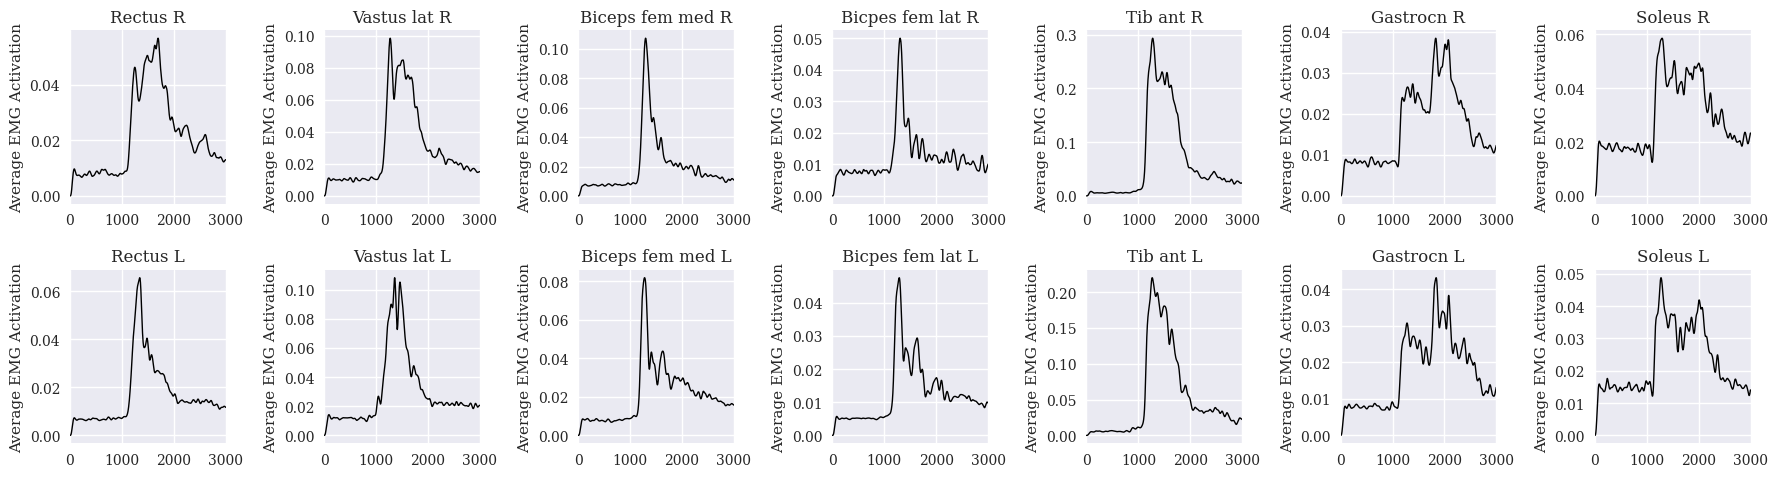

In [29]:
def aggregate_and_plot_emg_data(emg_data):
    # Initialize a dictionary to store aggregated data for each muscle
    muscle_data = {}

    # Aggregate data
    for entry in emg_data:
        data_dict = entry['data']
        for muscle, activations in data_dict.items():
            if muscle not in muscle_data:
                muscle_data[muscle] = []
            # Append data from each participant
            muscle_data[muscle].append(activations)

    # Calculate the average for each muscle and plot
    plt.figure(figsize=(18, 5))
    num_muscles = len(muscle_data)
    muscle_index = 1
    
    for muscle, data_list in muscle_data.items():
        if data_list:
            #print(data_list.shape)
            average_activation = np.mean(data_list, axis=0)
            print(average_activation[:10])
            # Create a subplot for each muscle
            ax = plt.subplot(2, 7, muscle_index)
            ax.plot(average_activation, c = 'black', linewidth = 1)
            ax.set_title(muscle)
            #ax.set_ylim([0, 1])
            ax.set_xlim([0, 3000])
            if num_muscles % 5 == 4:
                ax.set_ylabel('Average EMG Activation')
            muscle_index += 1

    plt.tight_layout()
    plt.savefig('./output/images/average_muscle_activations.png', format='png', bbox_inches='tight')
    plt.show()

aggregate_and_plot_emg_data(processed_data)

In [8]:
import pickle
import numpy as np
import matplotlib
import matplotlib.path as mplPath
import matplotlib.pyplot as plt
import os
import math
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors


name = '2025_01_22_22_53_000SAC'#'2024_11_04_16_24_37' #'2024_06_11_15_11_25' 
env_name = 'myoTorsoReachFixed-v1'
steps = 1000
cut = 100

pkl_path = './output/PKL/' + env_name + '/'
ep = 100


def load_pickle(file_path):
    with open(file_path, 'rb') as file:
        return pickle.load(file)

image_path = './image/' + env_name + '/' + name
os.makedirs(image_path, exist_ok=True)

bins = [0, 2, 4, 6, 8, 10]
bins_high = [20, 22, 24, 26, 28, 30]

In [9]:
AP_pert = []
AP_pert_1, ML_pert_1= [], []#this is only used for the scatter stand/fall plot
stand = []
fall = []
pert_1_AP, pert_2_AP, pert_3_AP, pert_4_AP, pert_5_AP = [], [], [], [], []
pert_1_ML, pert_2_ML, pert_3_ML, pert_4_ML, pert_5_ML = [], [], [], [], []
for i in range(ep):
    file_path = pkl_path + name+f'_{i}.pkl'  # Replace with actual file paths
    data = load_pickle(file_path)
    height = data['bodyInfo']['height']
    if height[-1] > 0.5:
        stand.append(data.copy())
    else:
        fall.append(data.copy())
    
    if data['modelInfo']['perturbationDirection'] == 1:
        AP_pert_1.append(data)
    else:
        ML_pert_1.append(data)

print(len(stand))
mass = 150

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x000001BADD123610>>
Traceback (most recent call last):
  File "c:\Users\chery\Documents\MyoBack\.venv\lib\site-packages\ipykernel\ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x000001BADD123610>>
Traceback (most recent call last):
  File "c:\Users\chery\Documents\MyoBack\.venv\lib\site-packages\ipykernel\ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


96


In [9]:
pert_1_AP_high, pert_2_AP_high, pert_3_AP_high, pert_4_AP_high, pert_5_AP_high = [], [], [], [], []
pert_AP = [pert_1_AP, pert_2_AP, pert_3_AP, pert_4_AP, pert_5_AP]
pert_AP_high = [pert_1_AP_high, pert_2_AP_high, pert_3_AP_high, pert_4_AP_high, pert_5_AP_high]
for data in stand:
    AP_pert.append(data)
    #data['jointInfo']['qacc'] = np.array(data['jointInfo']['qacc'])
    p_t = int(data['modelInfo']['perturbationTime']*100)
    acc = max(abs(arr[0]) for arr in data['jointInfo']['qacc']['slide_joint'][p_t: p_t + 20])
    print(acc)
    if bins[0] <= acc <= bins[1]:
        pert_1_AP.append(data)
    elif bins[1] <= acc <= bins[2]:
        pert_2_AP.append(data)
    elif bins[2] <= acc <= bins[3]:
        pert_3_AP.append(data)
    elif bins[3] <= acc <= bins[4]:
        pert_4_AP.append(data)
    elif bins[4] <= acc <= bins[5]:
        pert_5_AP.append(data)     
    elif bins_high[0] <= acc <= bins_high[1]:
        pert_1_AP_high.append(data)
    elif bins_high[1] <= acc <= bins_high[2]:
        pert_2_AP_high.append(data)
    elif bins_high[2] <= acc <= bins_high[3]:
        pert_3_AP_high.append(data)
    elif bins_high[3] <= acc <= bins_high[4]:
        pert_4_AP_high.append(data)
    elif bins_high[4] <= acc <= bins_high[5]:
        pert_5_AP_high.append(data)       


4.702748775732028
2.6904337117231973
0.6899616546693512
2.77867761080343
5.939522431765636
7.632393178066179
1.154770582946153
0.57179982542896
2.4035891411542365
7.496397512363727
6.431027164276878
1.3241129375582872
4.149312233073333
5.480015943840201
3.2100564527793467
3.32980731231706
4.628155976364241
5.471675362140351
1.5399814761514081
5.395205222897211
2.740552307886066
7.843299597998687
5.097147302010746
3.0355483771341367
9.263972758598912
5.01684494954323
3.881250142988829
6.044696769809276
3.879155200169852
7.512838553245394
6.946583748465427
8.693302595939373
5.641059278913181
8.499797999839378
3.954290445196579
2.4902670071836543
0.8381536244058857
9.280687053382943
2.184422093992107
6.970284393841581
2.766848025445384
4.940449467958036
5.794213166424861
3.9622474777371712
9.309797725345051
9.599637736489473
9.198436786007607
9.407805588108248
2.53944728621791
1.713367301314749
7.132507851661616
21.46588211535866
21.14118346310895
27.234979307773685
20.81887709918935
26.7

In [10]:
recfem_r, recfem_l = [], []
vaslat_r, vaslat_l = [], []
bflh_r, bflh_l = [], []
bfsh_r, bfsh_l = [], []
tibant_r, tibant_l = [], []
gaslat_r, gaslat_l = [], []
soleus_r, soleus_l = [], []

muscle_name = [recfem_r, recfem_l, vaslat_r, vaslat_l, bflh_r, bflh_l, bfsh_r, bfsh_l, tibant_r, tibant_l, gaslat_r, gaslat_l, soleus_r, soleus_l]


muscle_r = ['recfem_r', 'vaslat_r', 'bflh_r', 'bfsh_r', 'tibant_r', 'gaslat_r', 'soleus_r'] 
muscle_l = ['recfem_l', 'vaslat_l', 'bflh_l', 'bfsh_l', 'tibant_l', 'gaslat_l', 'soleus_l'] 

In [11]:
time_mo  = np.linspace(0, 5, 500)
y_range_joint = [-1, 1]
time_len = 500
x_time = np.arange(0, time_len/100, 0.01)
print(len(x_time))

500


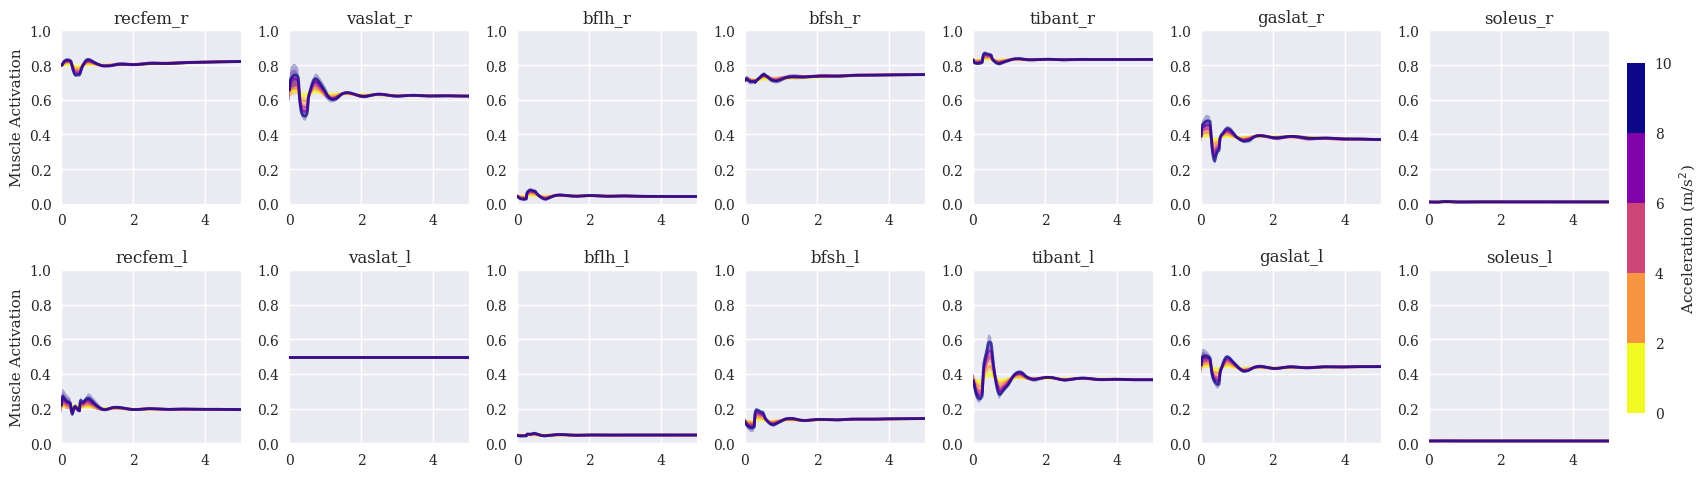

In [12]:
colormap = plt.cm.plasma_r
norm = mcolors.BoundaryNorm(bins, colormap.N)
fig, ax = plt.subplots(2, 7, figsize=(18, 5))

#fig= plt.figure(figsize=(18, 5))
for i in range(0, 7):
    plt.subplot(2, 7, i+1)
    for j in range(len(pert_AP)):
        l1, l2, l3, l4, l5 = [], [], [], [], []
        l = [l1, l2, l3, l4, l5]
        mean_pert = []
        for k in pert_AP[j]:
            p_t = int(k['modelInfo']['perturbationTime']*100)
            #if fatigue:
                #p_t += 2200
            l[j].append(k['muscleInfo']['muscleActivation'][muscle_r[i]][p_t:p_t+time_len])
            mean_pert.append(max(abs(arr[0]) for arr in k['jointInfo']['qacc']['slide_joint'][p_t: p_t+20]))
        if not l[j]:
            continue
        else:
            mean = np.mean(l[j], axis = 0)
            std = np.std(l[j], axis = 0)
            upper = mean + 2*std
            lower = mean - 2*std
            plt.plot(x_time, np.mean(l[j], axis= 0), c = colormap(norm(np.mean(mean_pert))), alpha = 0.7, linewidth = 2)
            plt.fill_between(x_time, lower.flatten(), upper.flatten(), facecolor = colormap(norm(np.mean(mean_pert))), alpha = 0.3)
    plt.title(muscle_r[i])
    plt.ylim([0, 1])
    if i == 0:
        plt.ylabel('Muscle Activation')

for i in range(0, 7):
    plt.subplot(2, 7, i+8)
    for j in range(len(pert_AP)):
        l1, l2, l3, l4, l5 = [], [], [], [], []
        l = [l1, l2, l3, l4, l5]
        mean_pert = []
        for k in pert_AP[j]:
            p_t = int(k['modelInfo']['perturbationTime']*100)
            #if fatigue:
                #p_t += 2200
            l[j].append(k['muscleInfo']['muscleActivation'][muscle_l[i]][p_t:p_t+time_len])
            mean_pert.append(max(abs(arr[0]) for arr in k['jointInfo']['qacc']['slide_joint'][p_t: p_t+20]))
        if not l[j]:
            continue
        else:
            mean = np.mean(l[j], axis = 0)
            std = np.std(l[j], axis = 0)
            upper = mean + 2*std
            lower = mean - 2*std
            plt.plot(x_time, np.mean(l[j], axis= 0), c = colormap(norm(np.mean(mean_pert))), alpha = 0.7, linewidth = 2)
            plt.fill_between(x_time, lower.flatten(), upper.flatten(), facecolor = colormap(norm(np.mean(mean_pert))), alpha = 0.3)
    plt.title(muscle_l[i])
    plt.ylim([0, 1])
    if i == 0:
        plt.ylabel('Muscle Activation')

sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm) 
sm.set_array([]) 
plt.tight_layout()
plt.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.91, 0.15, 0.01, 0.7])
cbar = plt.colorbar(sm, ticks=np.linspace(0, 10, 6), cax=cbar_ax) 
cbar.set_label(r'Acceleration (m/s$^2$)')


#txt="The ankle and hip angles (adduction, rotation and flexion) in response to perturbation in the range of 10  - 60N"
#plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=20)
plt.setp(ax, xlim=[0, time_len/100])

plt.savefig('./output/images/average_muscle_activations_sim.png', format='png', bbox_inches='tight')
plt.show()
plt.close()